# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle_data/train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [4]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

### Create a Prediction File

In [6]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4264615618442 median=600.0 std=684.7511617510816


In [7]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("kaggle_data/sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1692771/1710670


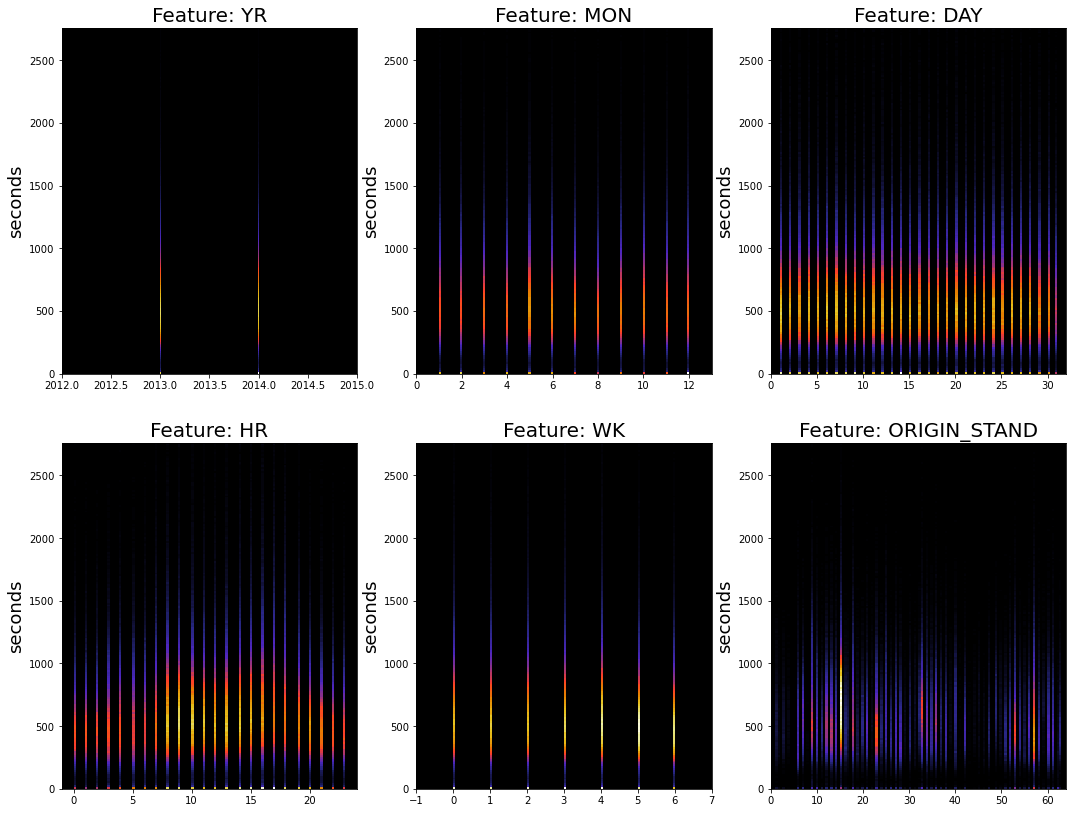

In [8]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


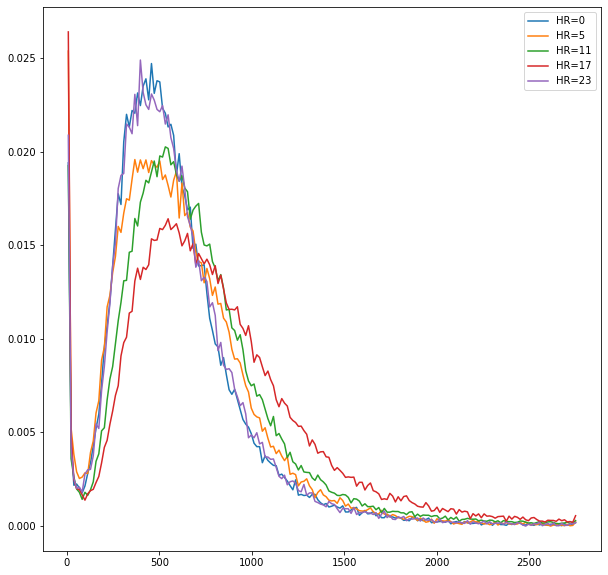

In [9]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

In [10]:
#More exploratory data analysis
#avgA = df_tr[df_tr['CALL_TYPE'] == 'A']['LEN'].mean()
print(avgA)

#avgB = df_tr[df_tr['CALL_TYPE'] == 'B']['LEN'].mean()
print(avgB)

#avgC = df_tr[df_tr['CALL_TYPE'] == 'C']['LEN'].mean()
print(avgC)

sns.barplot(data=df_tr,x='CALL_TYPE',y='LEN')

#It appears the calltype is significant

NameError: name 'avgA' is not defined

In [ ]:
print(df_tr['ORIGIN_STAND'].min())
df_stand = df_tr.dropna(subset = ['ORIGIN_STAND'])
print(df_stand.shape)
print(df_tr.shape)
sns.lineplot(data=df_stand,x='ORIGIN_STAND',y='LEN')
print(df_tr['ORIGIN_STAND'].max())

In [ ]:
print(df_tr['TAXI_ID'].value_counts())
sns.lineplot(data=df_stand,x='TAXI_ID',y='LEN')

In [ ]:
#dumb predictions
avgA = df_tr[df_tr['CALL_TYPE'] == 'A']['LEN'].median()
avgC = df_tr[df_tr['CALL_TYPE'] == 'C']['LEN'].median()
avgStand = []
for i in range(1,64):
    temp_frame = df_stand[df_stand['ORIGIN_STAND'] == i]
    avgStand.append(temp_frame['LEN'].median())
print(avgStand)

In [ ]:
row = df_tr.iloc[0]
print(row['CALL_TYPE'])

In [ ]:
def dumb_prediction(call):
    pred = 0
    if(call['CALL_TYPE'] == 'A'):
        return avgA
    if(call['CALL_TYPE'] == 'B'):
        return(int(avgStand[int(call['ORIGIN_STAND']-1)]))
    return avgC

In [ ]:
df_t = pd.read_csv("kaggle_data/test_public.csv")

In [ ]:
df_t.shape

In [ ]:
df_t.head()

In [ ]:
timeList = []
for i in range(len(df_t)):
    pred = dumb_prediction(df_t.iloc[i])
    timeList.append(pred)

In [ ]:
df_sample = pd.read_csv("kaggle_data/sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = timeList

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

In [ ]:
length = df_tr.shape[0]
print(length * 0.8)

In [ ]:
#Feature Engineering for one hot encoding
#Both Call_type and origin_call have effects on the length, but neither are linearly related so I am testing them with one hot encoding
df_tr = pd.get_dummies(data=df_tr,columns=['CALL_TYPE','ORIGIN_STAND'])
print(oneHot.shape)
print(oneHot.iloc[0])
cols = list(oneHot.columns)

cols.remove(['POLYLINE','TRIP_ID'])
print(cols)

In [ ]:
#cols.remove('POLYLINE')
#cols.remove('TRIP_ID')
print(cols)
actual_df = df[cols]

In [ ]:
#Okay Time for some actual neural network stuff
#Splitting the data into a training set and validation set
df_tr = df_tr.sample(frac=1) #shuffling up the data
print(df_tr.shape)
training = df_tr.iloc[0:1368536,:]
validation = df_tr.iloc[1368536:,:]
print(validation.shape)
print(training.shape)

In [ ]:
model = torch.nn.Sequential(
  torch.nn.Linear(1, 1),
)

# Define Loss Function / Objective Function
loss_fn = torch.nn.MSELoss()

# Define optimizer (this will perform your parameter updates use)
lr = 5e-3
opt = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
fig, ax = plt.subplots()
p = sns.histplot(data=df_tr,x='LEN',ax = ax)
ax.set_xlim(0,2000)
p

In [ ]:
print(df_tr['LEN'].value_counts())

In [15]:
print(df_tr.shape)

(1710670, 15)


In [16]:
print(df_t.shape)

NameError: name 'df_t' is not defined

In [39]:
ll_df = pd.read_csv('kaggle_data/metaData_taxistandsID_name_GPSlocation.csv')

In [40]:
ll_df.head()

,ID,Descricao,Latitude,Longitude
0,1,Agra,41.1771457135,-8.609670
1,2,Alameda,41.15618964,-8.591064
2,3,Aldoar,41.1705249231,-8.665876
3,4,Alfândega,41.1437639911,-8.621803
4,5,Amial,41.1835097223,-8.612726


In [68]:
def getlat(stand_id):
    if(np.isnan(stand_id)):
        return np.nan
    stand_id = int(stand_id)
    stand = ll_df.iloc[stand_id-1]
    lat = stand['Latitude']
    try:
        lat = float(lat)
    except Exception as e:
        lat = 41.163066654
    return float(lat)

def getlong(stand_id):
    if(np.isnan(stand_id)):
        return np.nan
    stand_id = int(stand_id)
    stand = (ll_df.iloc[stand_id-1])
    long = stand['Longitude']
    try:
        long = float(long)
    except Exception as e:
        long = -8.67598304213
    return float(long)

print(df_tr['ORIGIN_STAND'].value_counts())

15.0    80241
57.0    50882
9.0     34818
33.0    34128
23.0    33344
        ...  
41.0      506
43.0      493
8.0       381
5.0        53
48.0        7
Name: ORIGIN_STAND, Length: 63, dtype: int64


In [66]:
df_tr['LAT'] = df_tr['ORIGIN_STAND'].apply(getlat)
df_tr['LONG'] = df_tr['ORIGIN_STAND'].apply(getlong)
print(df_tr.columns)

TypeError: cannot convert the series to <class 'float'>

In [69]:
df_tr['LONG'] = df_tr['ORIGIN_STAND'].apply(getlong)

In [35]:
def setCount(inp):
    return 1
df_tr['COUNT'] = df_tr['TRIP_ID'].apply(setCount)

41.148628    80241
41.145719    50882
41.144253    34818
41.182787    34128
41.146016    33344
             ...  
41.163067      506
41.148611      493
41.151592      381
41.183510       53
41.171262        7
Name: LAT, Length: 63, dtype: int64
-8.585877    80241
-8.610707    50882
-8.605720    34818
-8.600122    34128
-8.612575    33344
             ...  
-8.621803     1153
-8.648886      493
-8.568195      381
-8.612726       53
-8.645050        7
Name: LONG, Length: 62, dtype: int64


<AxesSubplot:xlabel='LONG', ylabel='LAT'>

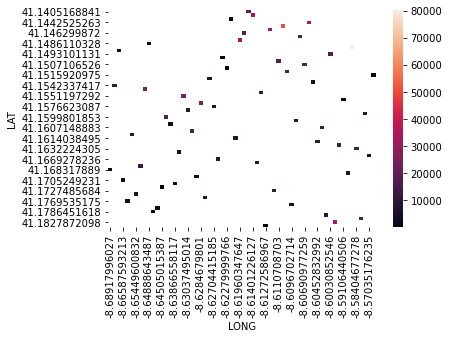

In [72]:
sV = df_tr['LAT'].value_counts()
print(sV)
print(df_tr['LONG'].value_counts())
tab = df_tr.pivot_table(index='LAT',columns='LONG',values='COUNT',aggfunc=np.sum)
sns.heatmap(data=tab)

<AxesSubplot:xlabel='LAT', ylabel='LONG'>

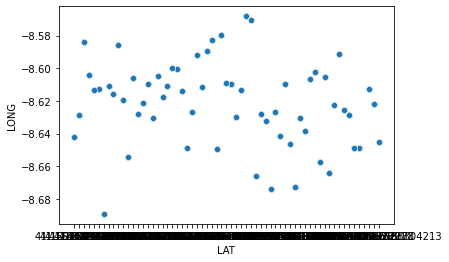

In [44]:
sns.scatterplot(data=df_tr,x='LAT',y='LONG')

#ind += jump
#sns.scatterplot(data=df_tr.iloc[ind:ind+jump],x='LAT',y='LONG')


In [70]:
heat_df = df_tr[['LAT','LONG']]

<AxesSubplot:>

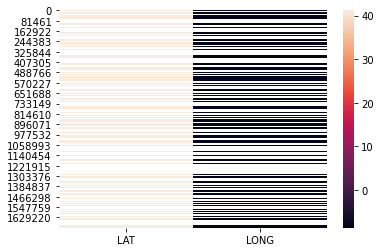

In [71]:
sns.heatmap(heat_df)